# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

* Based on best cutoff, may needed to re-do the phyloseq dataset partitioning (prior notebook)
* Using multiple 'heavy' BD windows for the DESeq2 analysis
  * 1 DESeq2 run per window
  * combining DESeq2 results
  * global adjustment of P-values

# Setting variables

In [1]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/Archaea/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/Archaea/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/Archaea/'
physeqFile = 'SIP-core'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

# Init

In [2]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [5]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


# Loading phyloseq

In [6]:
%%R -i physeqDir -i physeqFile 

F = file.path(physeqDir, physeqFile)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 147 taxa and 607 samples ]
sample_data() Sample Data:       [ 607 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 147 taxa by 7 taxonomic ranks ]


In [7]:
%%R
mdf = psmelt(physeq)
head(mdf)

         OTU               Sample Abundance          Full.sample Fraction
40331 OTU.20 13X.PTH.D7.R4.Frac29      1147 13X.PTH.D7.R4.Frac29       29
42742 OTU.21 12C.NTH.D3.R4.Frac26      1031 12C.NTH.D3.R4.Frac26       26
40570 OTU.20 12C.NTH.D3.R4.Frac28       974 12C.NTH.D3.R4.Frac28       28
67819 OTU.54 12C.NTH.D3.R4.Frac28       956 12C.NTH.D3.R4.Frac28       28
40522 OTU.20 13X.PTH.D7.R4.Frac27       932 13X.PTH.D7.R4.Frac27       27
40548 OTU.20 13X.PTH.D7.R4.Frac28       901 13X.PTH.D7.R4.Frac28       28
      PrimerF PrimerR Barcode Rev.index Fwd.index Treatment Day Replicate Pool
40331    515f    806r     100  cgagagtt  tacgagac       13X   7         4    1
42742    515f    806r     172  gtctgcta  tacgagac       12C   3         4    1
40570    515f    806r     174  gtctgcta  tcgacgag       12C   3         4    1
67819    515f    806r     174  gtctgcta  tcgacgag       12C   3         4    1
40522    515f    806r      98  cgagagtt  cgttacta       13X   7         4    1
40548   

In [8]:
%%R
unique(mdf$Rank3)

 [1] __Soil_Crenarchaeotic_Group(SCG)     __Marine_Group_I                    
 [3] __Halobacteria                       __Thermoplasmata                    
 [5] __Methanomicrobia                    __AK56                              
 [7] __Miscellaneous_Crenarchaeotic_Group __AK31                              
 [9] __terrestrial_group                  __Methanobacteria                   
10 Levels: __AK31 __AK56 __Halobacteria __Marine_Group_I ... __Thermoplasmata


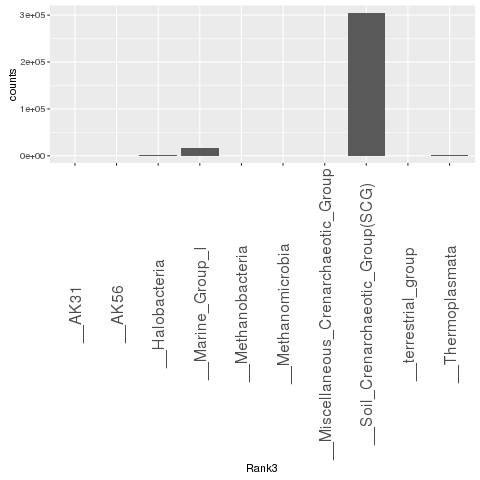

In [9]:
%%R
phyl.fig = mdf %>% group_by(Rank3, Rank2) %>% summarise(counts = sum(Abundance))

ggplot(data = phyl.fig, aes(Rank3, counts)) + geom_bar(stat = 'identity') + 
    theme( axis.text.x  = element_text(angle=90, vjust=0.5, size=16))

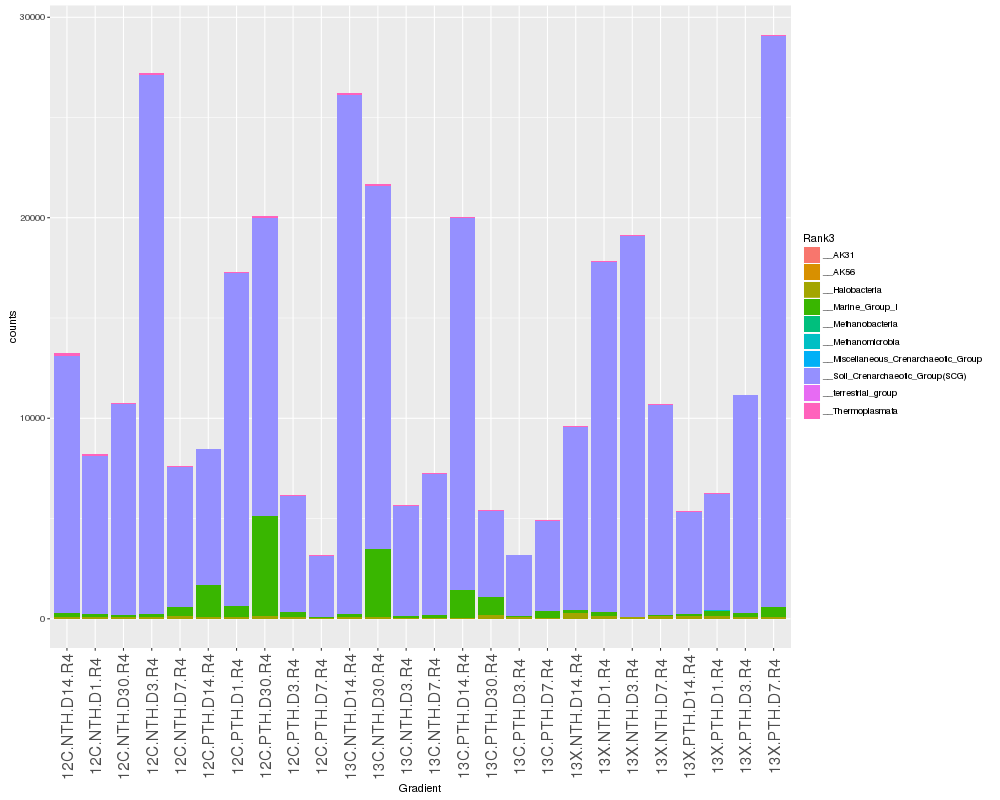

In [34]:
%%R -w 1000 -h 800
phyl.fig = mdf %>% group_by(Gradient, Rank3, Rank2) %>% summarise(counts = sum(Abundance))

ggplot(data = phyl.fig, aes(Gradient, counts, fill = Rank3)) + geom_bar(stat = 'identity') + 
    theme( axis.text.x  = element_text(angle=90, vjust=0.5, size=16))

In [ ]:
%%R -w 1000 -h 800
phyl.fig = mdf %>% filter(Rank2 != '__Thaumarchaeota') group_by(Gradient, Rank3, Rank2) %>% summarise(counts = sum(Abundance))

ggplot(data = phyl.fig, aes(Gradient, counts, fill = Rank3)) + geom_bar(stat = 'identity') + 
    theme( axis.text.x  = element_text(angle=90, vjust=0.5, size=16))

In [195]:
%%R
phyl.fig

Source: local data frame [10 x 3]
Groups: Rank3 [?]

                                  Rank3            Rank2 counts
                                 (fctr)           (fctr)  (dbl)
1                                __AK31 __Thaumarchaeota      1
2                                __AK56 __Thaumarchaeota      6
3                        __Halobacteria  __Euryarchaeota   2648
4                      __Marine_Group_I __Thaumarchaeota  16397
5                     __Methanobacteria  __Euryarchaeota      6
6                     __Methanomicrobia  __Euryarchaeota     35
7  __Miscellaneous_Crenarchaeotic_Group __Thaumarchaeota      2
8      __Soil_Crenarchaeotic_Group(SCG) __Thaumarchaeota 305370
9                   __terrestrial_group __Thaumarchaeota      4
10                     __Thermoplasmata  __Euryarchaeota   1440


## MW-HR-SIP

In [10]:
%%R
# check on number of gradients

n.gradient = physeq %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Treatment, Land_Management, Replicate) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 26 


In [12]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, l2fc_threshold, Treatment, Land_Management, Day, Replicate, 
                  sparsity_threshold, density_min, density_max){
        
    # function for calculating log2 fold change p-values
    Treatment = c(Treatment %>% as.character)
    physeq.md = sample_data(physeq.obj)
    
    # filtering
    p.12C = prune_samples((! is.na(physeq.md$Density)) &
                          (physeq.md$Treatment == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Land_Management == Land_Management),
                           physeq.obj)
    p.13C = prune_samples((! is.na(physeq.md$Density)) & 
                      (physeq.md$Treatment == Treatment) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate)&
                      (physeq.md$Land_Management == Land_Management),
                      physeq.obj)
    physeq.m = merge_phyloseq(p.12C, p.13C) 
    physeq.md = sample_data(physeq.m)
    p.12C = p.13C = NULL
    
    # sparcity cutoff applied to all gradient fractions
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)   
    
    # applying 'heavy' window pruning
    physeq.m = prune_samples((physeq.md$Density >= density_min) &
                             (physeq.md$Density <= density_max),  physeq.m)
    
    # removing 0-abundance taxa
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > 0 * length(x), TRUE)
        
    # sparsity cutoff applied to just heavy fractions
    #physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])

    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
        
    # setting pruning info
    d$density_min = density_min
    d$density_max = density_max
    d$sparsity_threshold = sparsity_threshold
    return(d)
}
                                                         

## Making a table of variable params for the multiple DESeq2 runs

In [13]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq %>% sample_data %>% 
    filter(! is.na(Density),
           Treatment != '12C') %>%
    select(Treatment, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Treatment, Day, Replicate, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)

[1] 16
  Treatment Day Replicate Land_Management
1       13C   3         4             NTH
2       13C   3         4             PTH
3       13C   7         4             NTH
4       13C   7         4             PTH
5       13C  14         4             NTH


In [14]:
%%R
# checking that there's only one microcosm replicate per treatment
sdm %>%
    group_by(Treatment, Day, Land_Management) %>%
    summarize(n_reps=n()) #%>%
   # group_by(n_reps) %>%
    #summarize(n_treatments = n())

Source: local data frame [16 x 4]
Groups: Treatment, Day [?]

   Treatment   Day Land_Management n_reps
      (fctr) (int)          (fctr)  (int)
1        13C     3             NTH      1
2        13C     3             PTH      1
3        13C     7             NTH      1
4        13C     7             PTH      1
5        13C    14             NTH      1
6        13C    14             PTH      1
7        13C    30             NTH      1
8        13C    30             PTH      1
9        13X     1             NTH      1
10       13X     1             PTH      1
11       13X     3             NTH      1
12       13X     3             PTH      1
13       13X     7             NTH      1
14       13X     7             PTH      1
15       13X    14             NTH      1
16       13X    14             PTH      1


In [15]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Treatment, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                   BD_windows = BD_windows,
                   sparsity_threshold = seq(0.05,0.5,0.05)) %>%
    separate(Var1, c('Treatment', 'Day', 'Replicate', 'Land_Management'), sep='___') %>%
    separate(BD_windows, c('density_min', 'density_max'), sep='-')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(n=3) %>% print
print('-------------------')
sdms %>% tail(n=3) %>% print

Number of pairwise combinations of variables: 480 

  Treatment Day Replicate Land_Management density_min density_max
1       13C   3         4             NTH        1.70        1.73
2       13C   3         4             PTH        1.70        1.73
3       13C   7         4             NTH        1.70        1.73
  sparsity_threshold
1               0.05
2               0.05
3               0.05
[1] "-------------------"
    Treatment Day Replicate Land_Management density_min density_max
478       13X   7         4             PTH        1.74        1.77
479       13X  14         4             NTH        1.74        1.77
480       13X  14         4             PTH        1.74        1.77
    sparsity_threshold
478                0.5
479                0.5
480                0.5


## DESeq2 runs

In [16]:
%%R 
registerDoParallel(nprocs)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = TRUE, 
                physeq.obj = physeq,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

df.l2fc %>% head(n=3) %>% as.data.frame


Error in do.ply(i) : 
  task 2 failed - "every gene contains at least one zero, cannot compute log geometric means"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in do.ply(i) : 
  task 2 failed - "every gene contains at least one zero, cannot compute log geometric means"

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **

In [17]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
saveRDS(df.l2fc, outFile)


Error in saveRDS(df.l2fc, outFile) : object 'df.l2fc' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in saveRDS(df.l2fc, outFile) : object 'df.l2fc' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [15]:
%pushnote 1_sparsity_cutoff DESeq2 complete

ERROR: Line magic function `%pushnote` not found.


## Summing number of rejected hypotheses per DESeq2 run

In [18]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'MWHRSIP_all-sparsity_df'), collapse='/')
df.l2fc = readRDS(inFile)
df.l2fc$Day = reorder(df.l2fc$Day, df.l2fc$Day %>% as.numeric)

# status
df.l2fc %>% head(n=3) %>% as.data.frame


Error in readRDS(inFile) : error reading from connection


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in readRDS(inFile) : error reading from connection

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [19]:
%%R -w 800 -h 300
df.l2fc.s = df.l2fc %>%
    unite(density_window, density_min, density_max, sep='-', remove=FALSE) %>%
    mutate(rej_hypo = padj < padj_cutoff) %>%
    group_by(density_window, sparsity_threshold, Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_rej_hypo = sum(rej_hypo, na.rm=TRUE)) 


ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_rej_hypo)) +
    geom_boxplot() +
    facet_wrap(~ density_window) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )


Error in eval(expr, envir, enclos) : object 'df.l2fc' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'df.l2fc' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [20]:
%%R -w 1000 -h 600
ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point() +
    facet_grid(Treatment ~ Day + Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )


Error in ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color = density_window,  : 
  object 'df.l2fc.s' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(df.l2fc.s, aes(sparsity_threshold, n_rej_hypo, color = density_window,  : 
  object 'df.l2fc.s' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [21]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 30, Treatment == '13C')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )


Error in eval(expr, envir, enclos) : object 'df.l2fc.s' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'df.l2fc.s' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [22]:
%%R -w 1000 -h 400

df.l2fc.s.test = df.l2fc.s %>% filter(Day == 3, Treatment == '13X')

ggplot(df.l2fc.s.test, aes(sparsity_threshold, n_rej_hypo, color=density_window, shape = Replicate)) +
    geom_point(size = 2) +
    facet_grid(Replicate ~ Land_Management) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1) 
    )


Error in eval(expr, envir, enclos) : object 'df.l2fc.s' not found


### Number of taxa for each  sparsity cutoff

In [23]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.s = df.l2fc %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold) %>%
    summarize(n_OTUs = OTU %>% unique %>% length) 

ggplot(df.l2fc.s, aes(sparsity_threshold %>% as.character, n_OTUs)) +
    geom_boxplot() +
    labs(x='Sparsity threshold', y='Number of OTUs') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        ) 


Error in eval(expr, envir, enclos) : object 'df.l2fc' not found


## For each treatment, selecting sparsity cutoff with most rejHypo

In [24]:
%%R
# selecting sparsity cutoffs
cat('Pre-filter:', df.l2fc %>% nrow, '\n')
df.l2fc.f = df.l2fc %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, density_min, density_max) %>% 
    mutate(n_rej_hypo = sum(padj < padj_cutoff, na.rm=TRUE)) %>%  # nRejHypos for each treat-spar-window combo
    group_by(Treatment, Day, Replicate, Land_Management, density_min, density_max) %>%
    filter(n_rej_hypo == max(n_rej_hypo)) %>%   # just best sparsity for treat-window combo
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, density_min, density_max, OTU) 
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')

df.l2fc.f %>% head(n=3) %>% as.data.frame


Error in eval(expr, envir, enclos) : object 'df.l2fc' not found


In [25]:
%%R -h 250
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


Error in ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) : 
  object 'df.l2fc.f' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) : 
  object 'df.l2fc.f' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Global correction of p-values

In [26]:
%%R
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    mutate(padj_global = p.adjust(p, method='BH'),
           padj_global = ifelse(padj_global < padj, padj, padj_global)) %>%
    ungroup() 

p1 = ggplot(df.l2fc.f, aes(padj, padj_global)) +
    geom_point(alpha=0.7) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

df.l2fc.f = df.l2fc.f %>%
    mutate(padj = padj_global) %>%
    select(-padj_global)

p1


Error in eval(expr, envir, enclos) : object 'df.l2fc.f' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'df.l2fc.f' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Selecting max l2fc for each treatment-OTU

In [27]:
%%R
cat('Pre-filter:', df.l2fc.f %>% nrow, '\n')
df.l2fc.f = df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, OTU) %>%
    filter(log2FoldChange == max(log2FoldChange, na.rm=TRUE)) %>%
    ungroup() %>%
    distinct(Treatment, Day, Replicate, Land_Management, OTU) %>%
    select(-n_rej_hypo)
cat('Post-filter:', df.l2fc.f %>% nrow, '\n')


Error in eval(expr, envir, enclos) : object 'df.l2fc.f' not found


In [28]:
%%R -h 500 -w 800
ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) +
    geom_boxplot() +
    labs(x='Heavy BD window (min)', y='Sparsity threshold') +
    theme_bw() +
    theme(
        text = element_text(size=16) 
    ) + facet_wrap(Land_Management ~ Replicate)


Error in ggplot(df.l2fc.f, aes(density_min, sparsity_threshold)) : 
  object 'df.l2fc.f' not found


In [29]:
%%R -w 650 -h 250
# plotting number of OTUs after filtering
df.l2fc.f.s = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>% filter(padj <=0.10) %>%
    group_by(Treatment, Day, Replicate, Land_Management) %>%
    summarize(n_OTUs = n()) 

ggplot(df.l2fc.f.s, aes(Day, n_OTUs, color=Land_Management, group=Replicate)) +
    geom_point()  + facet_wrap(~Treatment)
    #geom_line()


Error in eval(expr, envir, enclos) : object 'df.l2fc.f' not found


In [30]:
%%R
# checking that there's only 1 OTU value per treatment
df.l2fc.f %>%
    group_by(Treatment, Day, Replicate, Land_Management, sparsity_threshold, OTU) %>%
    summarize(n = n()) %>%
    ungroup %>%
    filter(n > 1) %>% as.data.frame


Error in eval(expr, envir, enclos) : object 'df.l2fc.f' not found


In [34]:
%%R -i workDir
# Writing out l2fc table

outFile = file.path(workDir, 'l2fc_sparse-maxRejH.txt')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

# Plotting the results

## l2fc plot

In [88]:
%%R
df.l2fc.f = read.table('/home/chantal/Chazy/Chazy_SIP/data/l2fc_sparse-maxRejH.txt', sep = '\t', header = TRUE)
df.l2fc.f$Substrate = df.l2fc.f$Treatment
df.l2fc.f$ls = as.character(paste(df.l2fc.f$Treatment, df.l2fc.f$Land_Management, sep = "-"))

In [77]:
%%R
resp_num = filter(df.l2fc.f, padj <=0.10)
print(length(resp_num$OTU))
print(length(unique(resp_num$OTU)))

[1] 5096
[1] 1913


In [86]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [4 x 2]

       ls  resp
    (chr) (int)
1 13C-NTH  1062
2 13C-PTH   935
3 13X-NTH   582
4 13X-PTH   604


In [87]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls, Day) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [16 x 3]
Groups: ls [?]

        ls   Day  resp
     (chr) (int) (int)
1  13C-NTH     3    17
2  13C-NTH     7   345
3  13C-NTH    14   545
4  13C-NTH    30   728
5  13C-PTH     3   185
6  13C-PTH     7   128
7  13C-PTH    14   412
8  13C-PTH    30   623
9  13X-NTH     1   127
10 13X-NTH     3   295
11 13X-NTH     7   282
12 13X-NTH    14   356
13 13X-PTH     1   161
14 13X-PTH     3   293
15 13X-PTH     7   296
16 13X-PTH    14   303


In [89]:
%%R
N.X = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10)
P.X = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10)
N.C = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10)
P.C = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10)

In [90]:
%%R
print(length(intersect(N.X$OTU, P.X$OTU)))
print(length(intersect(N.X$OTU, N.C$OTU)))
print(length(intersect(N.X$OTU, P.C$OTU)))
print(length(intersect(P.X$OTU, N.C$OTU)))
print(length(intersect(P.X$OTU, P.C$OTU)))
print(length(intersect(N.C$OTU, P.C$OTU)))

[1] 352
[1] 263
[1] 224
[1] 269
[1] 281
[1] 440


In [92]:
%%R
length(Reduce(intersect, list(N.X$OTU, P.X$OTU, N.C$OTU, P.C$OTU)))

[1] 116


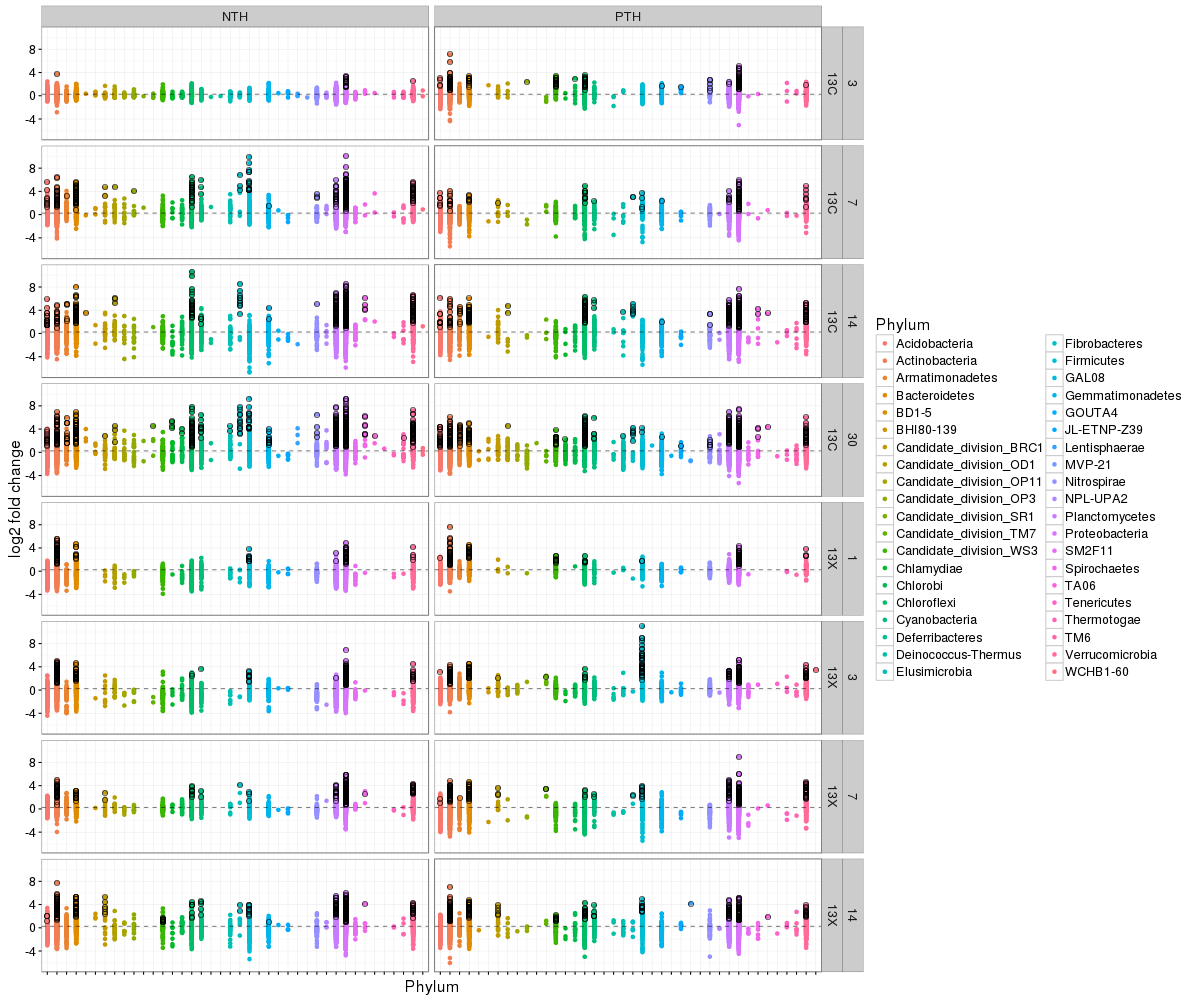

In [73]:
%%R -w 1200 -h 1000

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

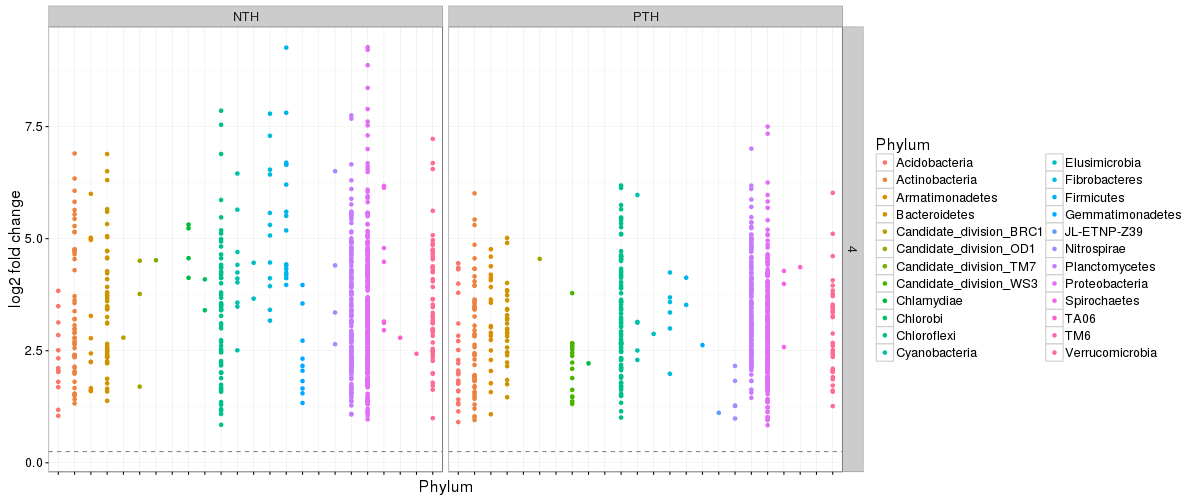

In [38]:
%%R -w 1200 -h 500
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13C', Day == 30) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

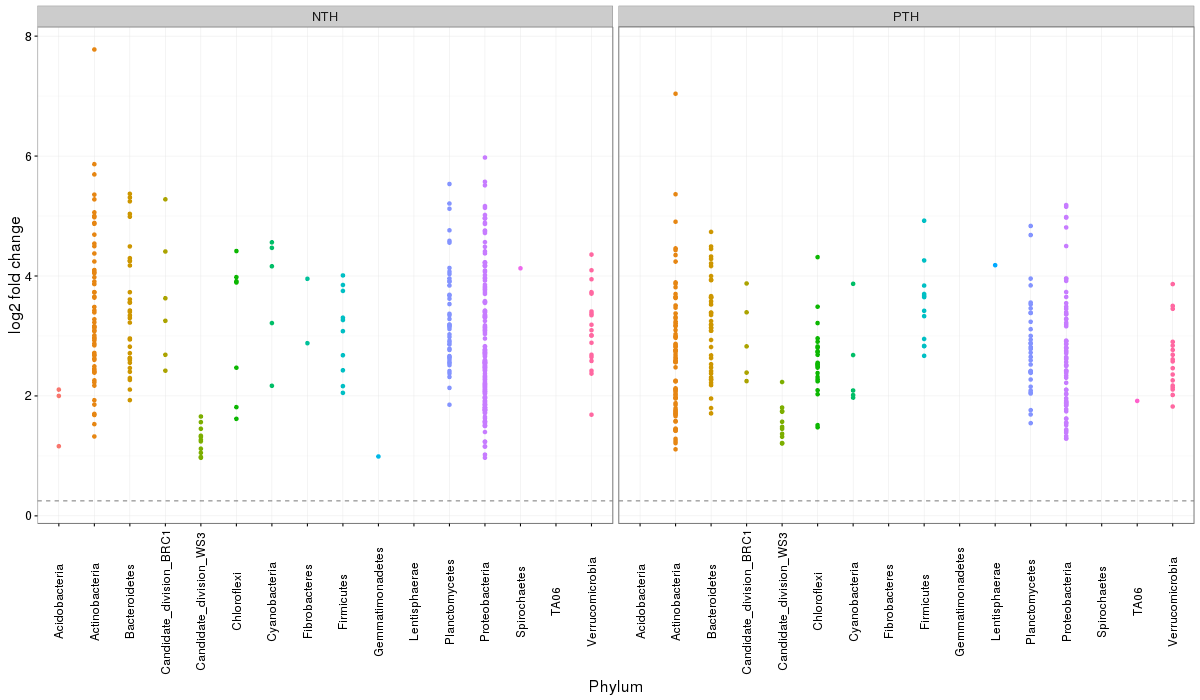

In [39]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 14) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid( .~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

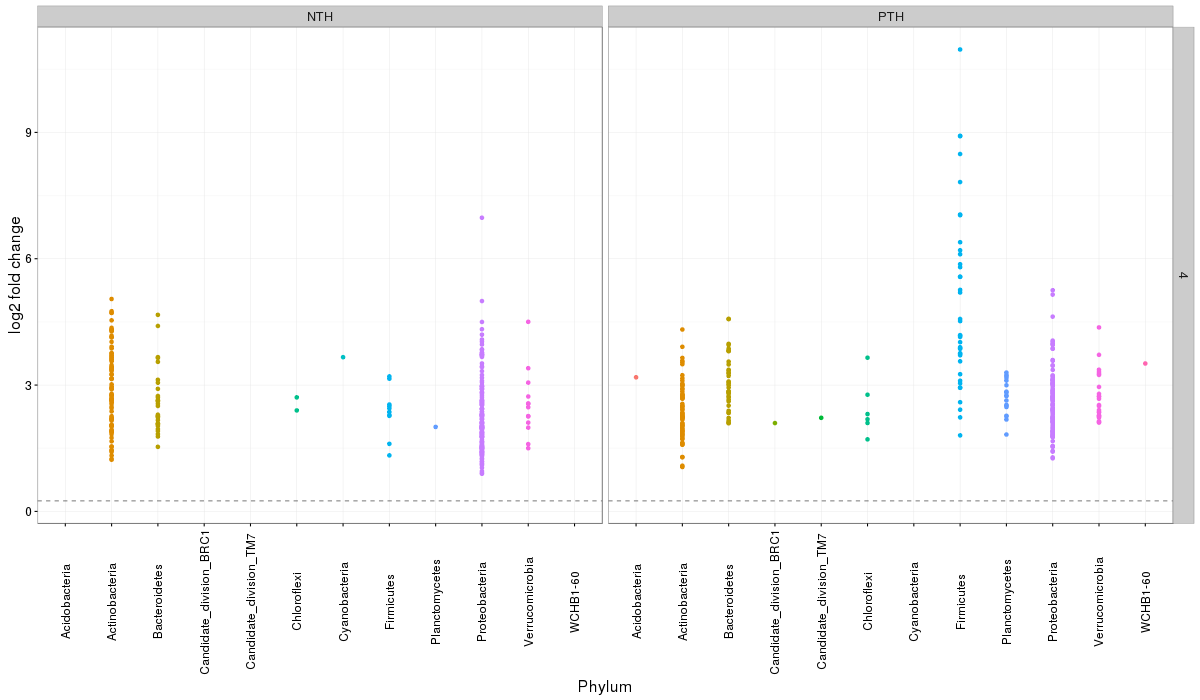

In [40]:
%%R -w 1200 -h 700
#Just significant OTUs...

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj < padj_cutoff, Treatment == '13X', Day == 3) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.sig, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)
p.l2fc

In [34]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=12, height=9)

### Example figure

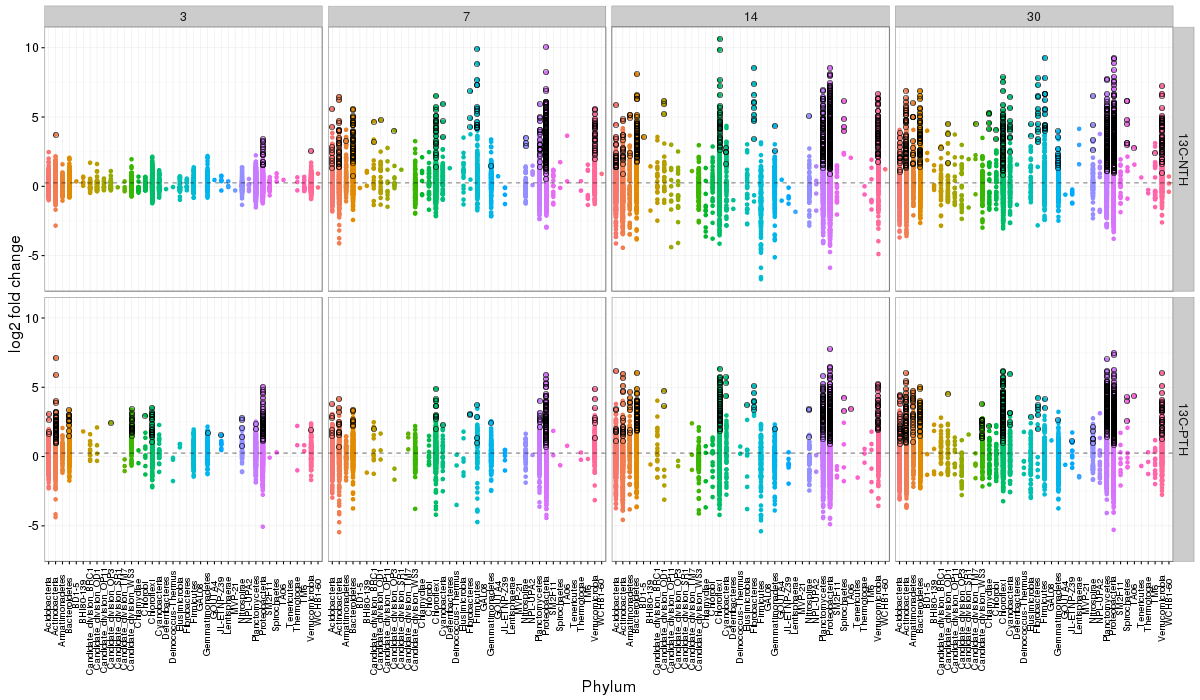

In [170]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13C') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, hjust = 0.8, size=9)) +#,
        #axis.text.x = element_blank() 
         guides(color = FALSE)
p.l2fc.x

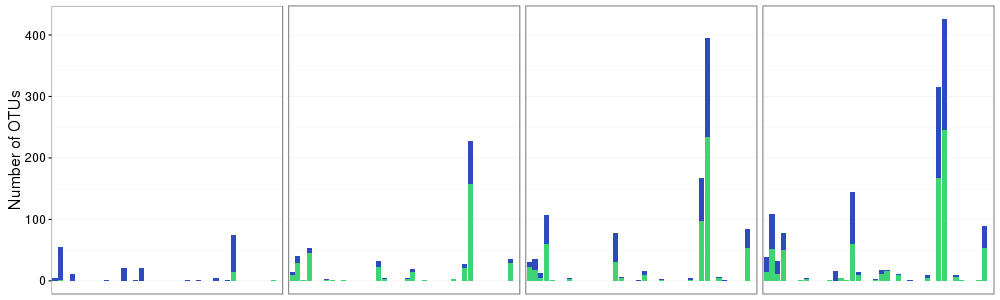

In [173]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.l2fc.f.f %>% group_by(Day,Rank2, ls) %>% summarise(resp = sum(padj <=0.10))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Rank2, y = resp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Number of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [174]:
%%R -w 1500 -h 300
#Normalizing by every phyla, every day

hist.cell = df.l2fc.f.f %>% group_by(Day,Rank2) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

In [179]:
%%R
day = 30

hist.cell3 %>% filter(realresp >0.6, Day == day) %>% ungroup %>% arrange(Day, ls) %>% as.data.frame

   Day      ls                   Rank2  realresp
1   30 13C-NTH           Bacteroidetes 0.6410256
2   30 13C-NTH Candidate_division_BRC1 1.0000000
3   30 13C-NTH  Candidate_division_OD1 0.7500000
4   30 13C-NTH  Candidate_division_TM7 1.0000000
5   30 13C-NTH              Chlamydiae 0.8000000
6   30 13C-NTH                Chlorobi 1.0000000
7   30 13C-NTH           Cyanobacteria 0.6666667
8   30 13C-NTH           Elusimicrobia 0.6666667
9   30 13C-NTH           Fibrobacteres 0.6666667
10  30 13C-NTH              Firmicutes 0.8888889
11  30 13C-NTH        Gemmatimonadetes 0.9090909
12  30 13C-NTH            Spirochaetes 0.7000000
13  30 13C-NTH                     TM6 1.0000000
14  30 13C-NTH         Verrucomicrobia 0.6067416
15  30 13C-PTH           Acidobacteria 0.6410256
16  30 13C-PTH         Armatimonadetes 0.6250000
17  30 13C-PTH  Candidate_division_WS3 1.0000000
18  30 13C-PTH             JL-ETNP-Z39 1.0000000


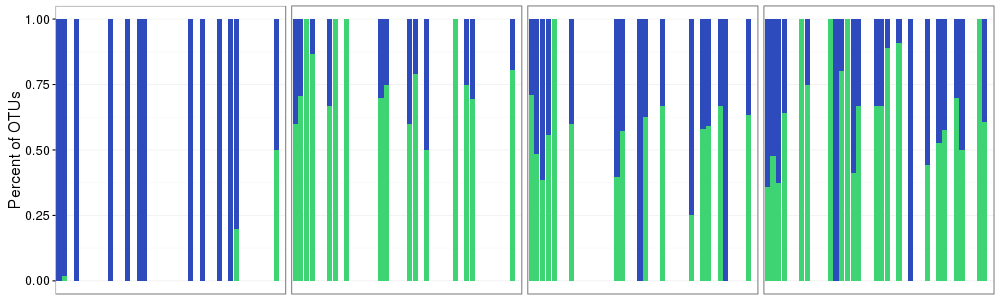

In [161]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [155]:
%%R -w 1500 -h 300
#Normalizing by every day

hist.cell = df.l2fc.f.f %>% group_by(Day) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

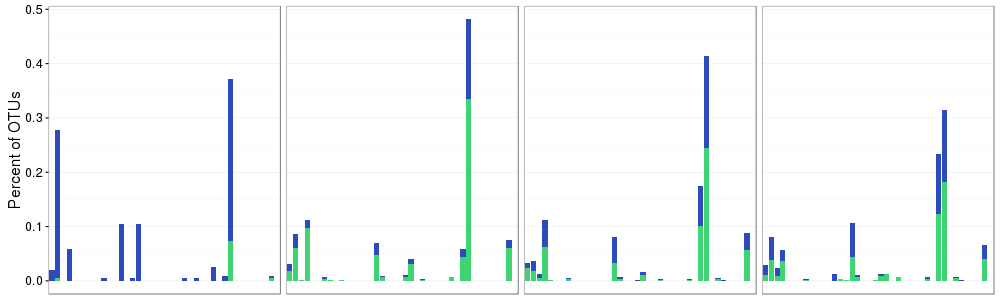

In [156]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [152]:
%%R -w 1500 -h 300
#Normalizing over entire dataset

hist.cell = df.l2fc.f.f %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

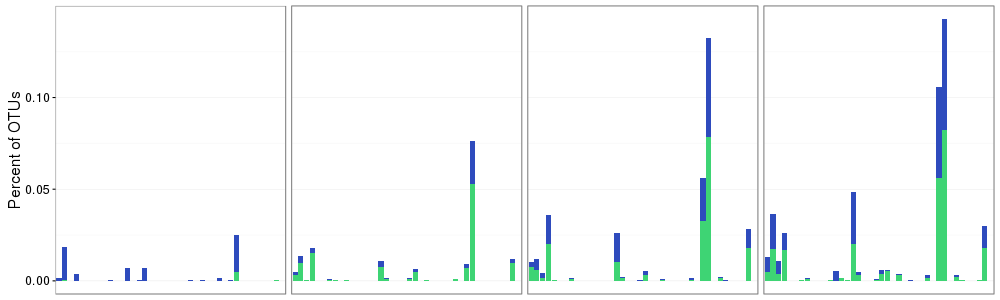

In [153]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

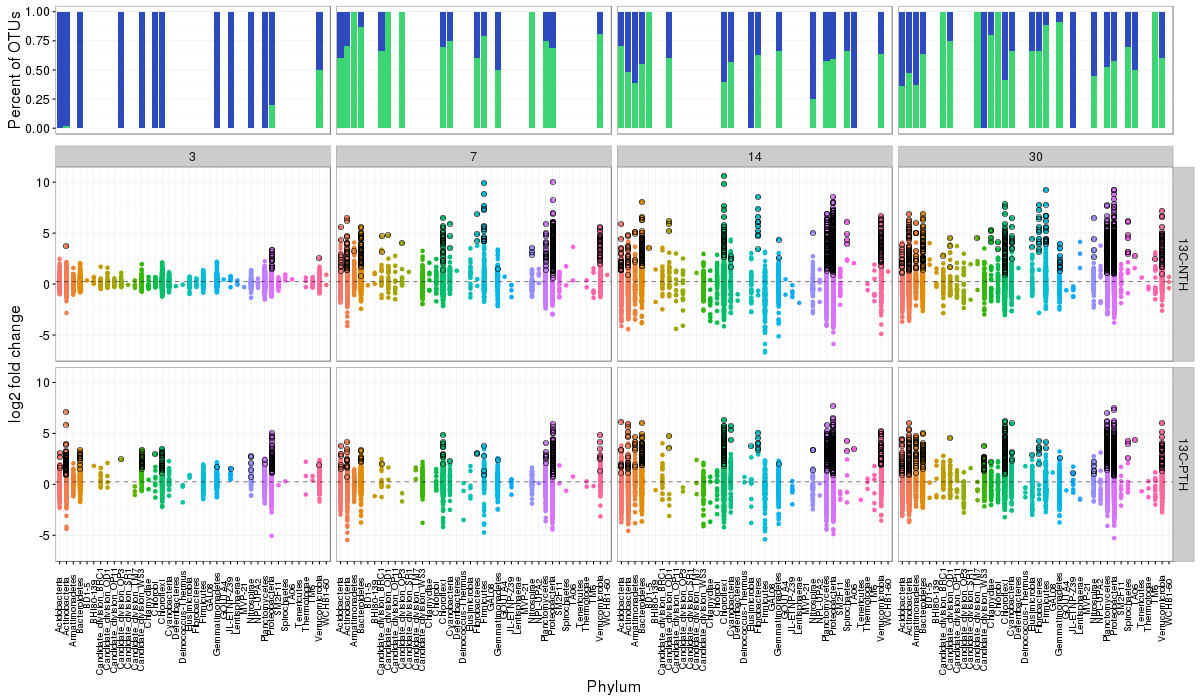

In [162]:
%%R -w 1200 -h 700
library(cowplot)

##CHANGE NUMBER TO PERCENT??

plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 10))


In [67]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylumX.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=4)

outFile = 'l2fc_sparCutMax_byPhylumX2.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=16, height=8)

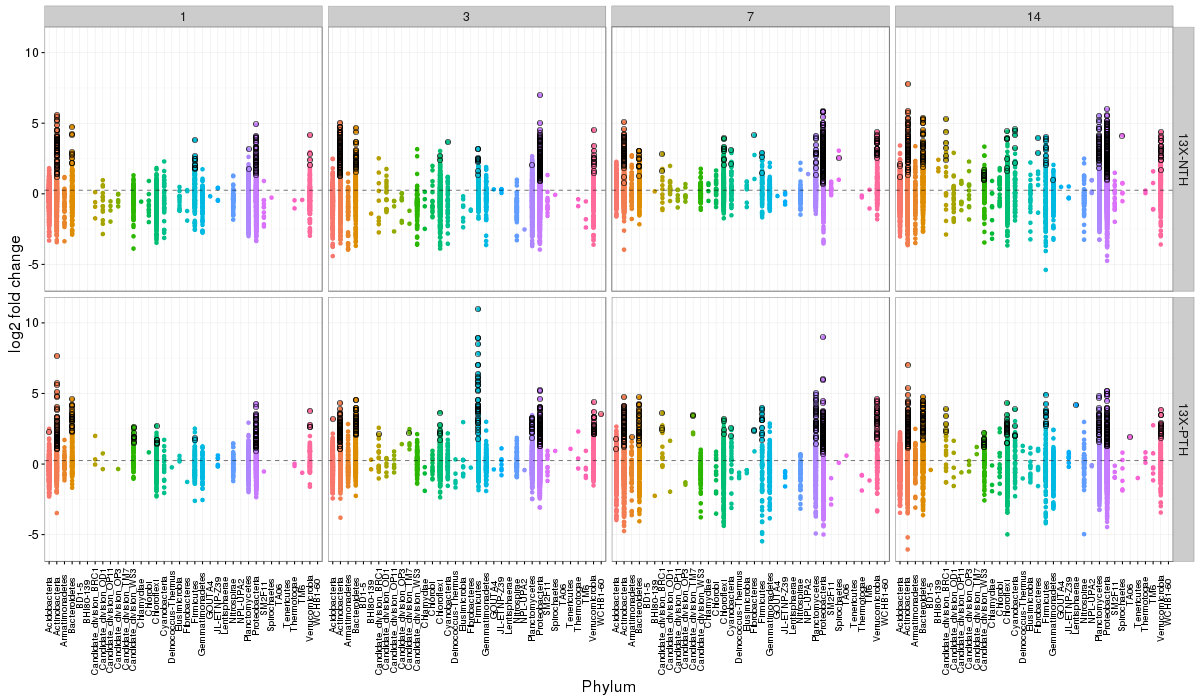

In [163]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16), axis.text.x  = element_text(angle=90, vjust=0.4, hjust = 0.8, size=9)) +#,
        #axis.text.x = element_blank() 
         guides(color = FALSE)
p.l2fc.x

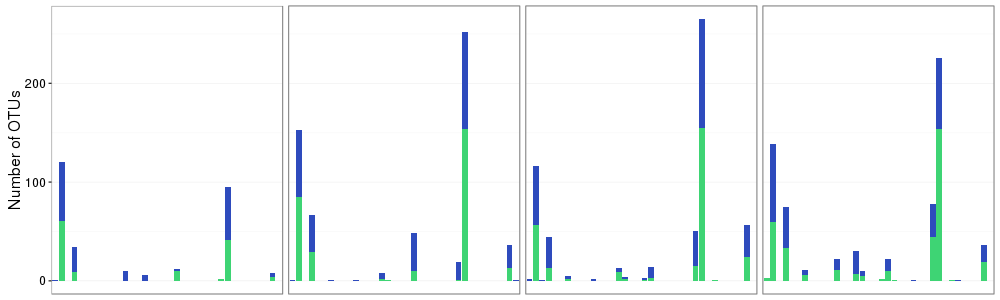

In [164]:
%%R -w 1000 -h 300

hist.cell.nonorm = df.l2fc.f.f %>% group_by(Day,Rank2, ls) %>% summarise(resp = sum(padj <=0.10))


p.test = ggplot() + geom_bar(data = hist.cell.nonorm, aes(x = Rank2, y = resp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Number of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [165]:
%%R -w 1500 -h 300
#Normalizing by every phyla, every day

hist.cell = df.l2fc.f.f %>% group_by(Day,Rank2) %>% mutate(respbyphyl = sum(padj <=0.10))
hist.cell2 = hist.cell %>% ungroup %>% group_by(Day, ls, Rank2, respbyphyl) %>% mutate(respcounts = sum(padj <=0.10))

hist.cell2$percresp = hist.cell2$respcounts/hist.cell2$respbyphyl
#hist.cell2[is.na(hist.cell2)] <- 0

hist.cell3 = hist.cell2 %>% group_by(Day, ls, Rank2) %>% summarise(realresp = mean(percresp))

In [168]:
%%R
day = 14

hist.cell3 %>% filter(realresp >0.6, Day == day) %>% ungroup %>% arrange(Day, ls) %>% as.data.frame

  Day      ls            Rank2  realresp
1  14 13X-NTH    Acidobacteria 1.0000000
2  14 13X-NTH    Fibrobacteres 1.0000000
3  14 13X-NTH Gemmatimonadetes 1.0000000
4  14 13X-NTH   Proteobacteria 0.6814159
5  14 13X-NTH     Spirochaetes 1.0000000
6  14 13X-PTH      Chloroflexi 0.7666667
7  14 13X-PTH    Lentisphaerae 1.0000000
8  14 13X-PTH             TA06 1.0000000
9  14 13X-PTH             <NA> 1.0000000


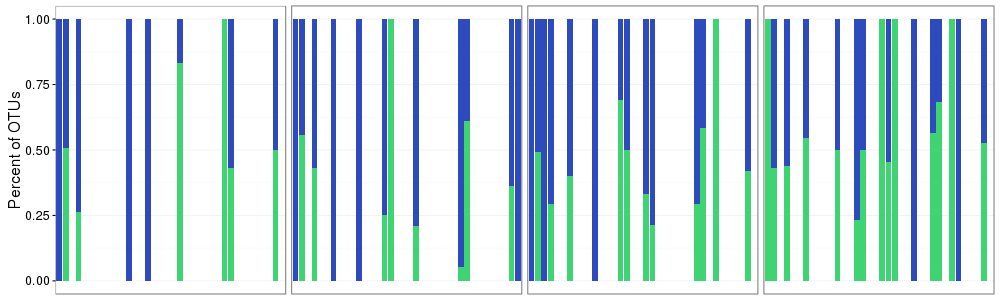

In [167]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.cell3, aes(x = Rank2, y = realresp, group = ls,fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Percent of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

In [83]:
%%R -w 1500 -h 300

hist.xyl = df.l2fc.f.f %>% group_by(Day, ls, Rank2) %>% summarise(respcounts = sum(padj <=0.10))
hist.xyl[is.na(hist.xyl)] <- 0

head(hist.xyl)

Source: local data frame [6 x 4]
Groups: Day, ls [1]

    Day      ls                   Rank2 respcounts
  (int)   (chr)                   (chr)      (int)
1     1 13X-NTH           Acidobacteria          0
2     1 13X-NTH          Actinobacteria         61
3     1 13X-NTH         Armatimonadetes          0
4     1 13X-NTH           Bacteroidetes          9
5     1 13X-NTH Candidate_division_BRC1          0
6     1 13X-NTH  Candidate_division_OD1          0


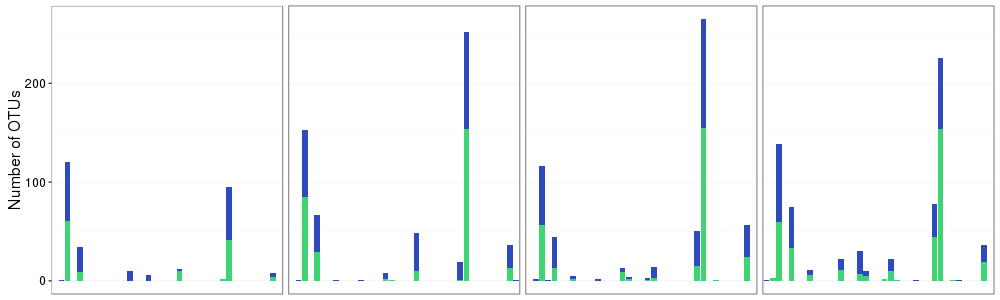

In [84]:
%%R -w 1000 -h 300
p.test = ggplot() + geom_bar(data = hist.xyl, aes(x = Rank2, y = respcounts, fill = ls), stat = 'identity',
                             position = 'stack') +
    facet_grid(1~Day) + theme_bw() + scale_fill_manual(name = 'Condition', values = c("#3ed474",
"#2e4bbd")) + theme(text = element_text(size = 16), axis.title.x = element_blank()) +
        ylab('Number of OTUs') +  scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) 
p.test

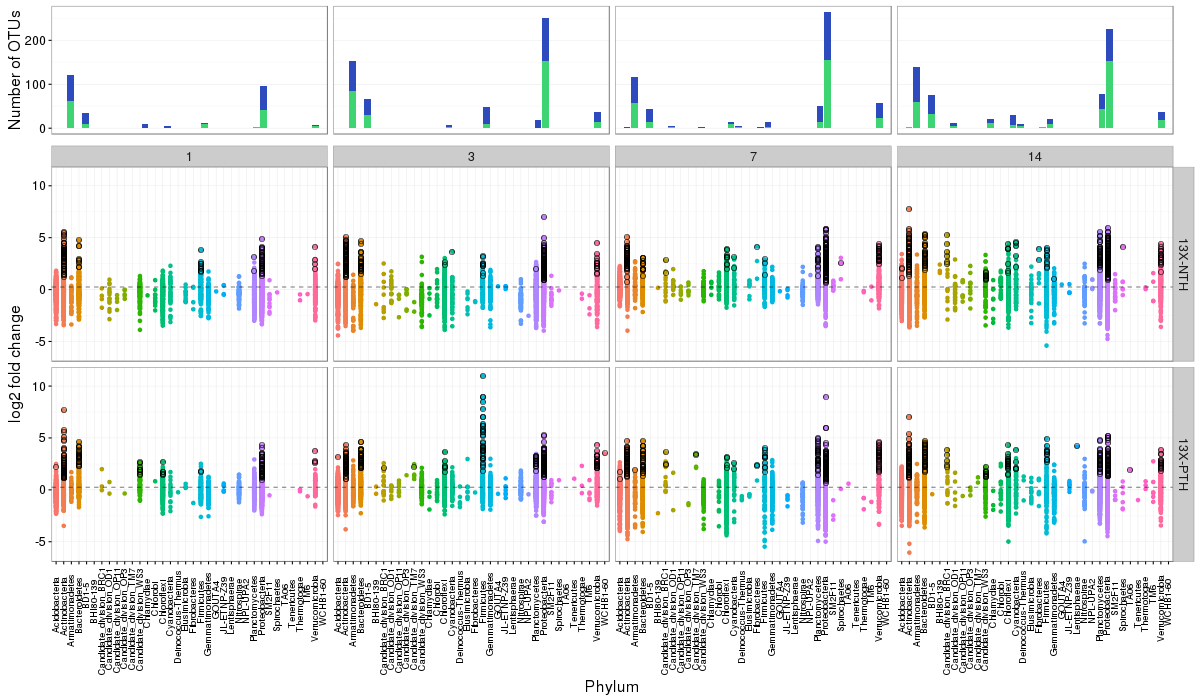

In [85]:
%%R -w 1200 -h 700
library(cowplot)

plot_grid(p.test, p.l2fc.x, nrow = 2, align = 'v', rel_heights = c(2.5, 10))


## l2fc plot of the richest phyla in the dataset

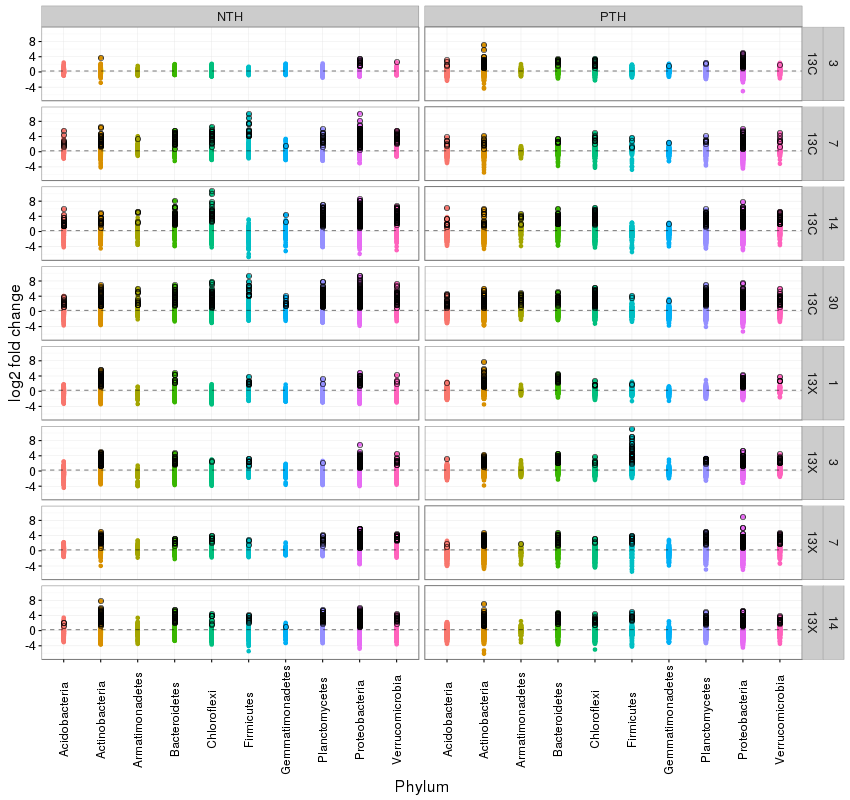

In [42]:
%%R -w 850 -h 800

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Treatment ~ Day ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
         axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

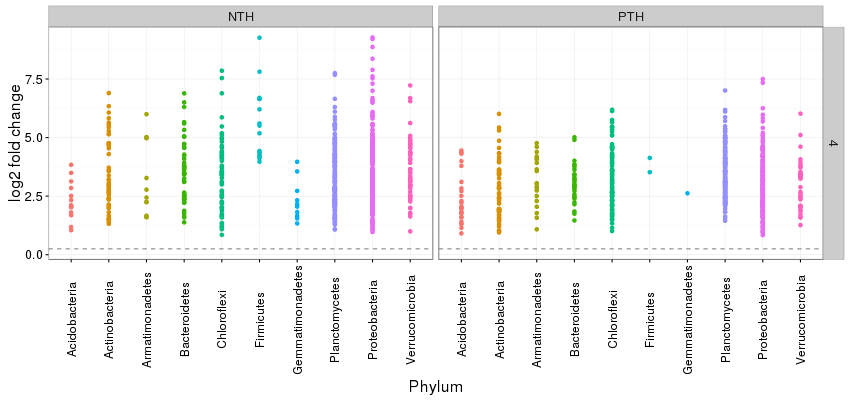

In [43]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13C', Day == '30', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

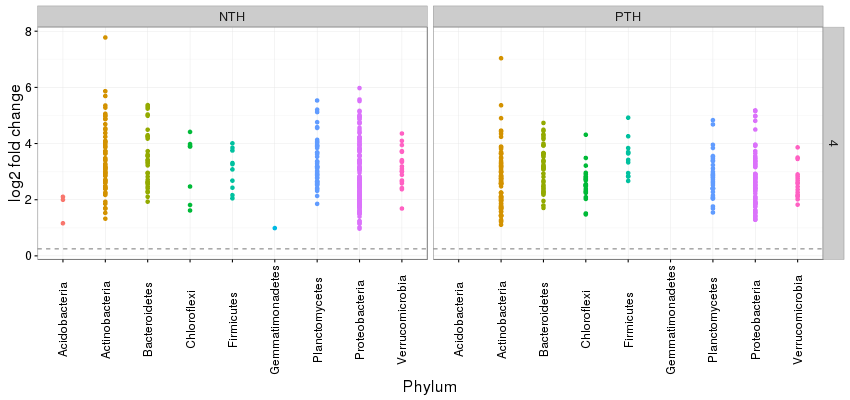

In [44]:
%%R -w 850 -h 400

df.l2fc.f.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(Rank2) %>%
    mutate(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() %>%
    mutate(n_OTU_rank = dense_rank(-n_OTU)) %>%
    filter(n_OTU_rank <= 10, Treatment == '13X', Day == '14', padj <=0.10) 

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj < padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    #geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(Replicate ~ Land_Management) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
       axis.text.x  = element_text(angle=90, vjust=0.5, size=12)
        )  + guides(color = FALSE)

df.l2fc.f.f = NULL
df.l2fc.f.f.sig = NULL

p.l2fc

In [45]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_byPhylum-rich10.pdf'
outFile = file.path(figDir, outFile)
ggsave(outFile, p.l2fc, width=11, height=9)

### Number of incorporators per treatment

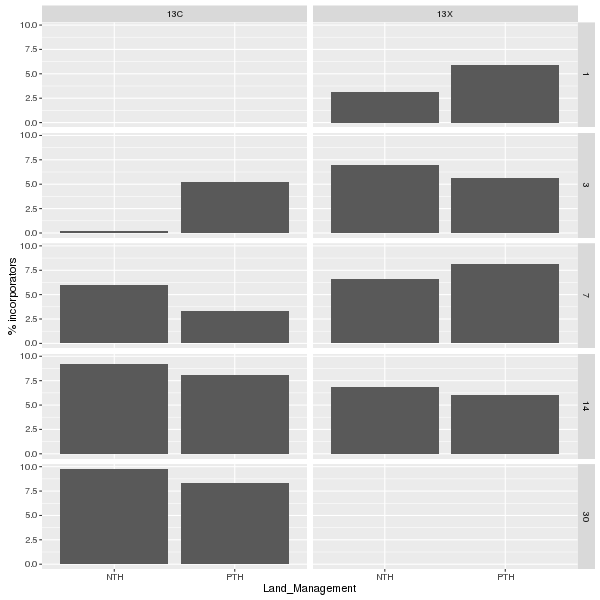

In [47]:
%%R -h 600 -w 600


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)

p.nIncSub = ggplot(df.l2fc.f.Sig, aes(Land_Management, n_incorp_perc)) +
    geom_bar(stat='identity') + 
    labs(y='% incorporators') + facet_grid(Day~Treatment)
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        )
p.nIncSub

#### Notes

* The figure shows the number of incorporators normalized by the number of taxa in observed in any gradient fraction associated with that substrate.

### Number of incorporators per treatment/time

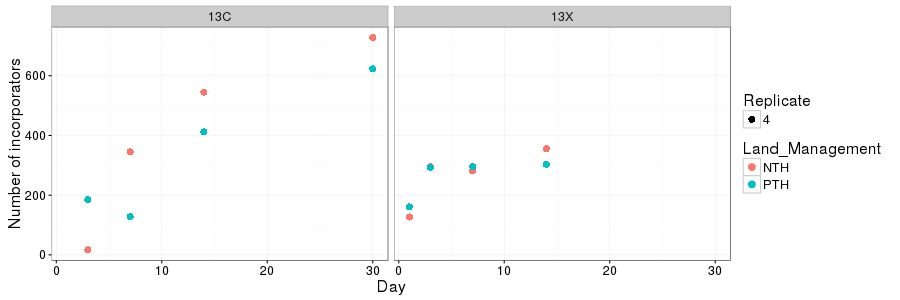

In [48]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(n = sum(padj < padj_cutoff)) %>%
    ungroup()

p.nInc = ggplot(df.l2fc.f.sig, aes(Day, n, color=Land_Management, group=Land_Management, shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Number of incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) + facet_wrap(~Treatment)
p.nInc

### Number of incorporators normalized by number of taxa in each sample

In [49]:
%%R
df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    summarize(ntaxa = n())

Source: local data frame [16 x 5]
Groups: Treatment, Day, Land_Management [?]

   Treatment    Day Land_Management Replicate ntaxa
       (chr) (fctr)           (chr)     (chr) (int)
1        13C      3             NTH         4  7422
2        13C      3             PTH         4  3551
3        13C      7             NTH         4  5758
4        13C      7             PTH         4  3810
5        13C     14             NTH         4  5923
6        13C     14             PTH         4  5122
7        13C     30             NTH         4  7443
8        13C     30             PTH         4  7504
9        13X      1             NTH         4  4101
10       13X      1             PTH         4  2747
11       13X      3             NTH         4  4235
12       13X      3             PTH         4  5204
13       13X      7             NTH         4  4240
14       13X      7             PTH         4  3644
15       13X     14             NTH         4  5178
16       13X     14             PTH  

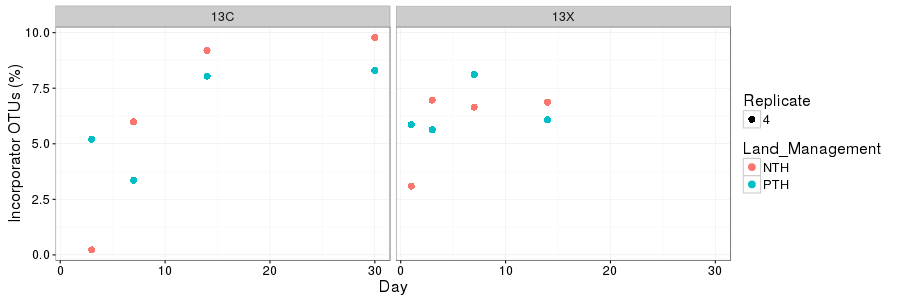

In [50]:
%%R -w 900 -h 300

df.l2fc.f.sig = df.l2fc.f %>%
    mutate(Day = Day %>% as.character %>% as.numeric) %>%
    group_by(Treatment, Day, Land_Management, Replicate) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Replicate, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup()

p.nInc.norm = ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, group=Land_Management,
                                        shape = Replicate)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        ) + facet_wrap(~Treatment)
p.nInc.norm

In [46]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm, width=10, height=3.5)

In [47]:
%%R -i figDir
outFile = 'l2fc_sparCutMax_nIncNorm-labile.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm.labile, width=10, height=3.5)


Error in grid.draw(plot) : object 'p.nInc.norm.labile' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.draw(plot) : object 'p.nInc.norm.labile' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

  res = super(Function, self).__call__(*new_args, **new_kwargs)


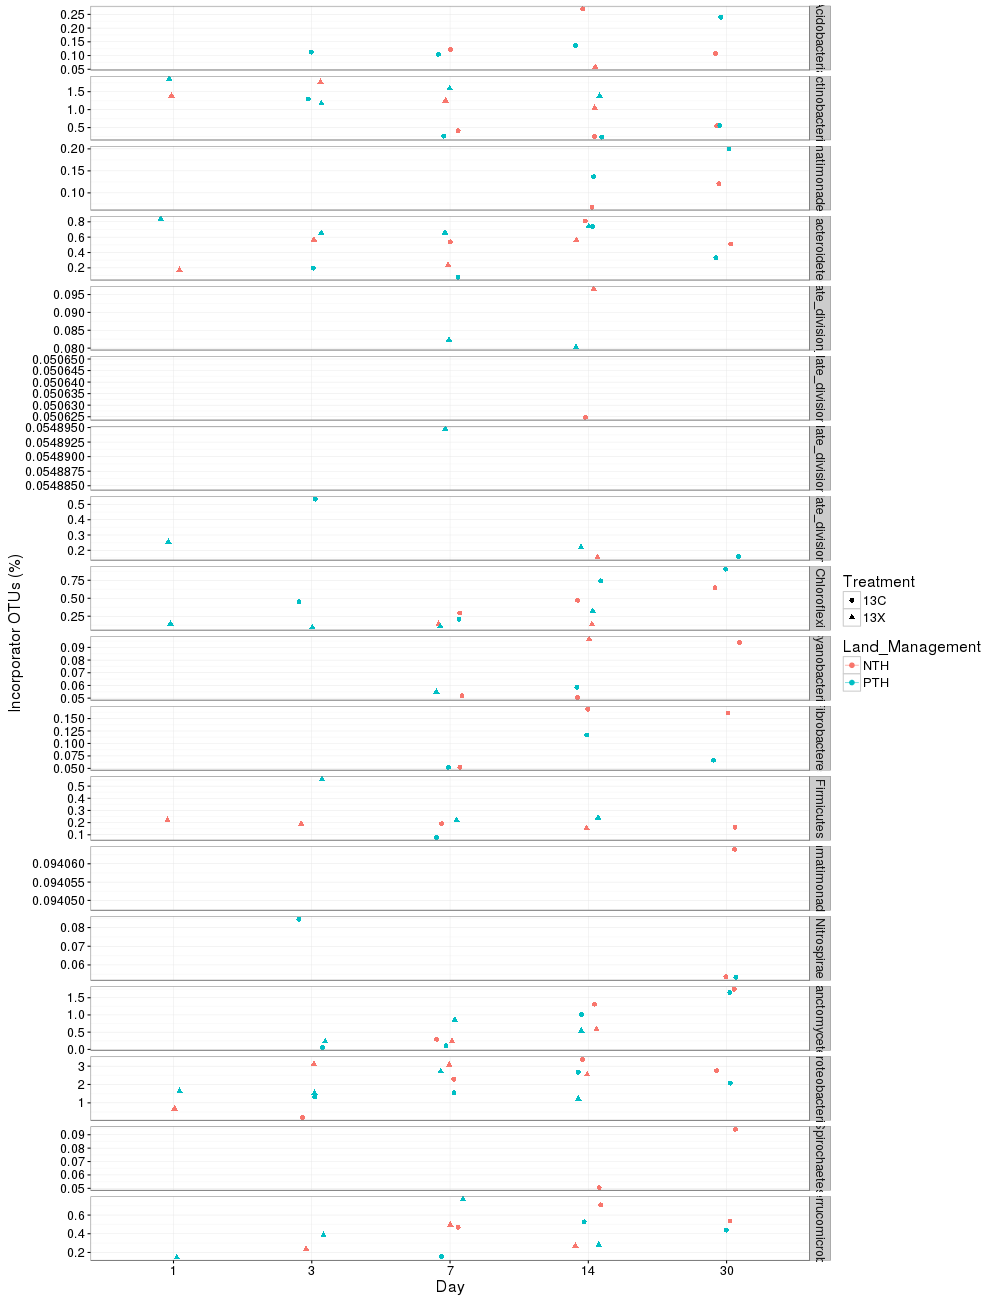

In [51]:
%%R -w 1000 -h 1300

padj_cutoff = 0.05
n_incorp_norm_perc_cutoff = 0.05

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(Treatment, Day, Land_Management) %>%
    mutate(ntaxa = n()) %>%
    group_by(Treatment, Day, Land_Management, Rank2, ntaxa) %>%
    summarize(n_incorp = sum(padj < padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    filter(n_incorp_norm_perc >= n_incorp_norm_perc_cutoff)

ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Land_Management, shape = Treatment)) +
    geom_jitter(size = 2, width = 0.25) +
    geom_line(alpha=0.5) +
    facet_grid(Rank2 ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

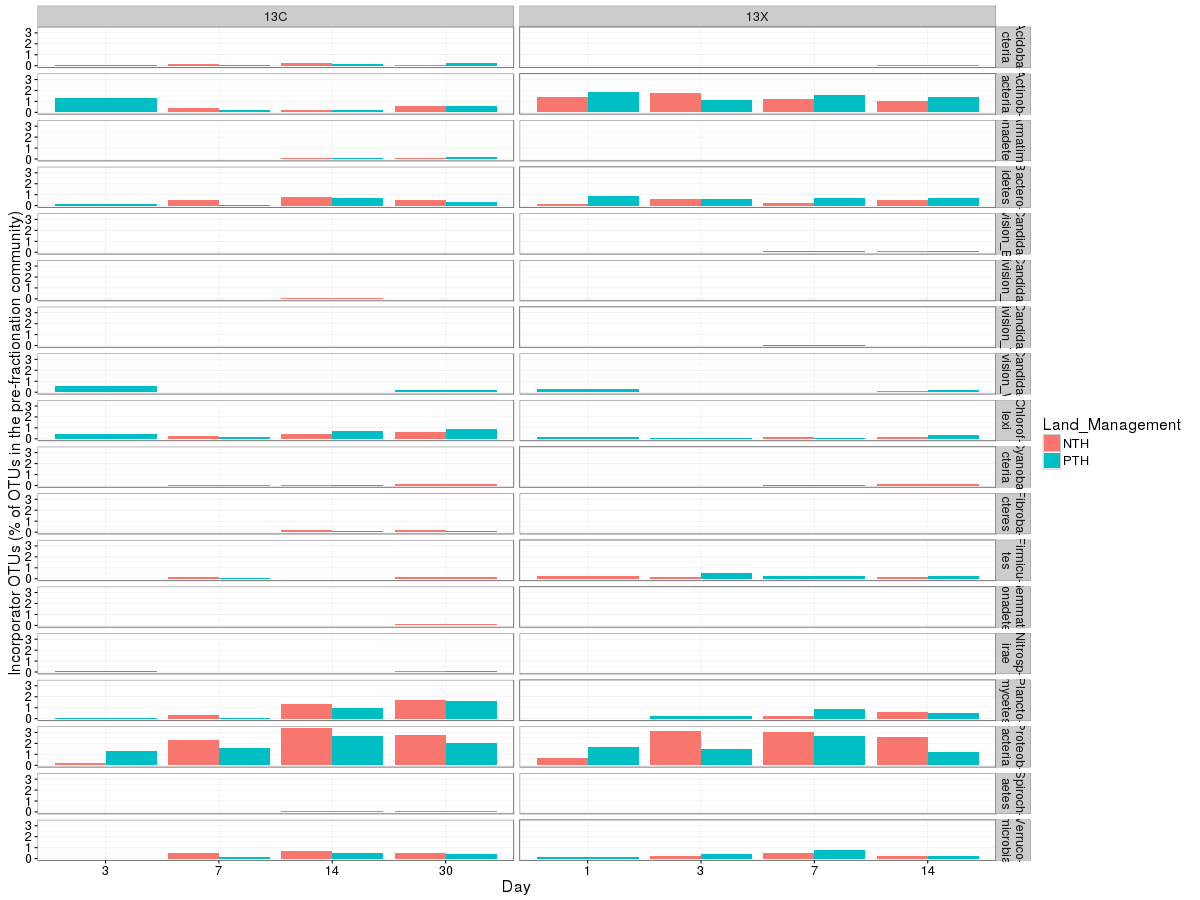

In [52]:
%%R -w 1200 -h 900

df.l2fc.f.sig.e = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.e$Day = reorder(df.l2fc.f.sig.e$Day, df.l2fc.f.sig.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.e, aes(Day, n_incorp_norm_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_x', space='free') +
    labs(y='Incorporator OTUs (% of OTUs in the pre-fractionation community)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        ) 

## Plotting normalized by total taxa in phylulm

In [53]:
%%R
n_OTUs_phylum = df.l2fc.f %>% 
    group_by(Treatment, Land_Management, Day, Rank2) %>%
    summarize(n_OTUs = n())

n_OTUs_phylum

Source: local data frame [517 x 5]
Groups: Treatment, Land_Management, Day [?]

   Treatment Land_Management    Day                   Rank2 n_OTUs
       (chr)           (chr) (fctr)                   (chr)  (int)
1        13C             NTH      3           Acidobacteria    794
2        13C             NTH      3          Actinobacteria    953
3        13C             NTH      3         Armatimonadetes    103
4        13C             NTH      3           Bacteroidetes    338
5        13C             NTH      3                   BD1-5      1
6        13C             NTH      3               BHI80-139      5
7        13C             NTH      3 Candidate_division_BRC1     25
8        13C             NTH      3  Candidate_division_OD1     34
9        13C             NTH      3 Candidate_division_OP11     12
10       13C             NTH      3  Candidate_division_OP3     26
..       ...             ...    ...                     ...    ...


In [54]:
%%R

df.l2fc.f.sig.j = inner_join(df.l2fc.f.sig, n_OTUs_phylum, c('Day' = 'Day',
                                                              'Treatment' = 'Treatment',
                                                              'Land_Management' = 'Land_Management',
                                                              'Rank2' = 'Rank2')) %>%
                    mutate(n_incorp_normByPhylum_perc = n_incorp / n_OTUs * 100)
                             
df.l2fc.f.sig.j %>% head(n=3) %>% as.data.frame 

  Treatment Day Land_Management          Rank2 ntaxa n_incorp
1       13C   3             NTH Proteobacteria  7422       15
2       13C   3             PTH  Acidobacteria  3551        4
3       13C   3             PTH Actinobacteria  3551       46
  n_incorp_norm_perc n_OTUs n_incorp_normByPhylum_perc
1          0.2021019   2141                  0.7006072
2          0.1126443    422                  0.9478673
3          1.2954097    513                  8.9668616


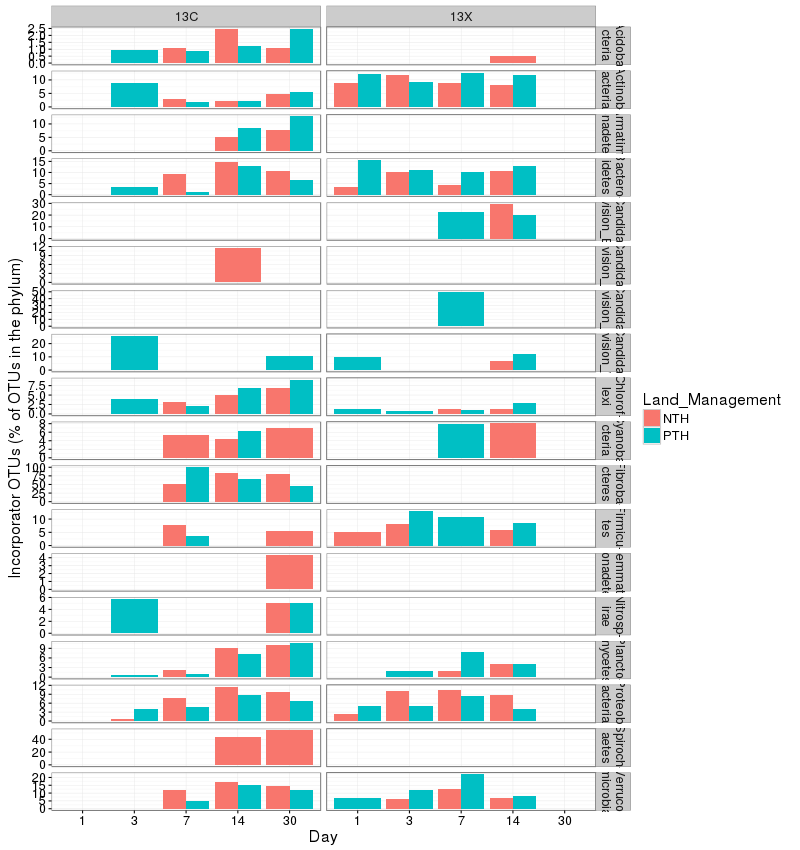

In [55]:
%%R -w 800 -h 850

df.l2fc.f.sig.j.e = df.l2fc.f.sig.j %>%
    mutate(Day = Day %>% as.character,
           Rank2 = gsub('^(.{7})', '\\1-\n', Rank2))

df.l2fc.f.sig.j.e$Day = reorder(df.l2fc.f.sig.j.e$Day, df.l2fc.f.sig.j.e$Day %>% as.numeric)

ggplot(df.l2fc.f.sig.j.e, aes(Day, n_incorp_normByPhylum_perc, fill=Land_Management)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(Rank2 ~ Treatment, scales='free_y', space='fixed') +
    labs(y='Incorporator OTUs (% of OTUs in the phylum)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )